# Import Statements

In [56]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [68]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
spikes_file = filepath_root+'ankit/spikes.csv'
time_high_file = filepath_root+'ankit/time_high_3H.pkl'
time_low_file = filepath_root+'ankit/time_low_3H.pkl'
space_high_file = filepath_root+'ankit/space_high_3H.pkl'
space_low_file = filepath_root+'ankit/space_low_3H.pkl'

# Data Loading

In [69]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Hotspots

In [119]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [120]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [121]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Plot Spatial Hotspots

In [122]:
shsp_high = np.array(shsp_high)
shsp_low = np.array(shsp_low)

/state/partition1/job-18677675/ipykernel_2190656/1418123353.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_high = np.array(shsp_high)
/state/partition1/job-18677675/ipykernel_2190656/1418123353.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_low = np.array(shsp_low)


In [144]:
hsp = deepcopy(shsp_high[88])
hsp

array([Timestamp('2018-06-13 00:00:00+0530', tz='pytz.FixedOffset(330)'),
       'NSIT_CPCB', list([])], dtype=object)

In [145]:
hsps_high = shsp_high[shsp_high[:,0]==hsp[0]]
# hsps_low = shsp_low[shsp_low[:,0]==hsp[0]]
# hsps = np.concatenate((hsps_high,hsps_low))
hsps = hsps_high
ts = hsps[0][0]
print(hsps)

for i in range(len(hsps)):
    hsp = hsps[i]
    hsp_nns = []
    for pl in hsp[2]:
        if(abs(df.loc[hsp[0]][hsp[1]]-df.loc[hsp[0]][pl])<50):
            hsp_nns.append(pl)
    hsps[i][2] = hsp_nns
hsps_n = []
for i in range(len(hsps)):
    hsps_n.append([hsps[i][1]]+hsps[i][2])
hsps = hsps_n
hsps

[[Timestamp('2018-06-13 00:00:00+0530', tz='pytz.FixedOffset(330)')
  'IHBAS_CPCB' list(['ITO_CPCB'])]
 [Timestamp('2018-06-13 00:00:00+0530', tz='pytz.FixedOffset(330)')
  'Jahangirpuri_DPCC' list(['Wazirpur_DPCC', 'Shadipur_CPCB'])]
 [Timestamp('2018-06-13 00:00:00+0530', tz='pytz.FixedOffset(330)')
  'MDCNS_DPCC' list([])]
 [Timestamp('2018-06-13 00:00:00+0530', tz='pytz.FixedOffset(330)')
  'NSIT_CPCB' list([])]]


[['IHBAS_CPCB', 'ITO_CPCB'],
 ['Jahangirpuri_DPCC', 'Wazirpur_DPCC', 'Shadipur_CPCB'],
 ['MDCNS_DPCC'],
 ['NSIT_CPCB']]

In [147]:
hsps

[['IHBAS_CPCB', 'ITO_CPCB'],
 ['Jahangirpuri_DPCC', 'Wazirpur_DPCC', 'Shadipur_CPCB'],
 ['MDCNS_DPCC'],
 ['NSIT_CPCB']]

In [148]:
val_df = deepcopy(df.loc[ts])

In [149]:
val_df = val_df.fillna(val_df.mean())

In [150]:
locs_map = locs.loc[val_df.index]

In [151]:
locs_map = locs_map.drop(labels='Pusa_DPCC')
locs_map = locs_map.rename(index={'Pusa_IMD':'Pusa_IMD_DPCC'})
# locs_map

In [152]:
val_df = (val_df-val_df.min())/(val_df.max()-val_df.min())

In [153]:
val_df.loc['Pusa_IMD_DPCC'] = (val_df.loc['Pusa_IMD']+val_df.loc['Pusa_DPCC'])/2
val_df.drop(labels=['Pusa_IMD', 'Pusa_DPCC'])
val_df

field_egg_id
113E                     0.379845
1FD7                     0.039345
20CA                     0.043055
2E9C                     0.379845
3ACF                     0.379845
                           ...   
SoniaVihar_DPCC          0.391544
SriAurobindoMarg_DPCC    0.379845
VivekVihar_DPCC          0.403347
Wazirpur_DPCC            0.824876
Pusa_IMD_DPCC            0.438084
Name: 2018-06-13 00:00:00+05:30, Length: 61, dtype: float64

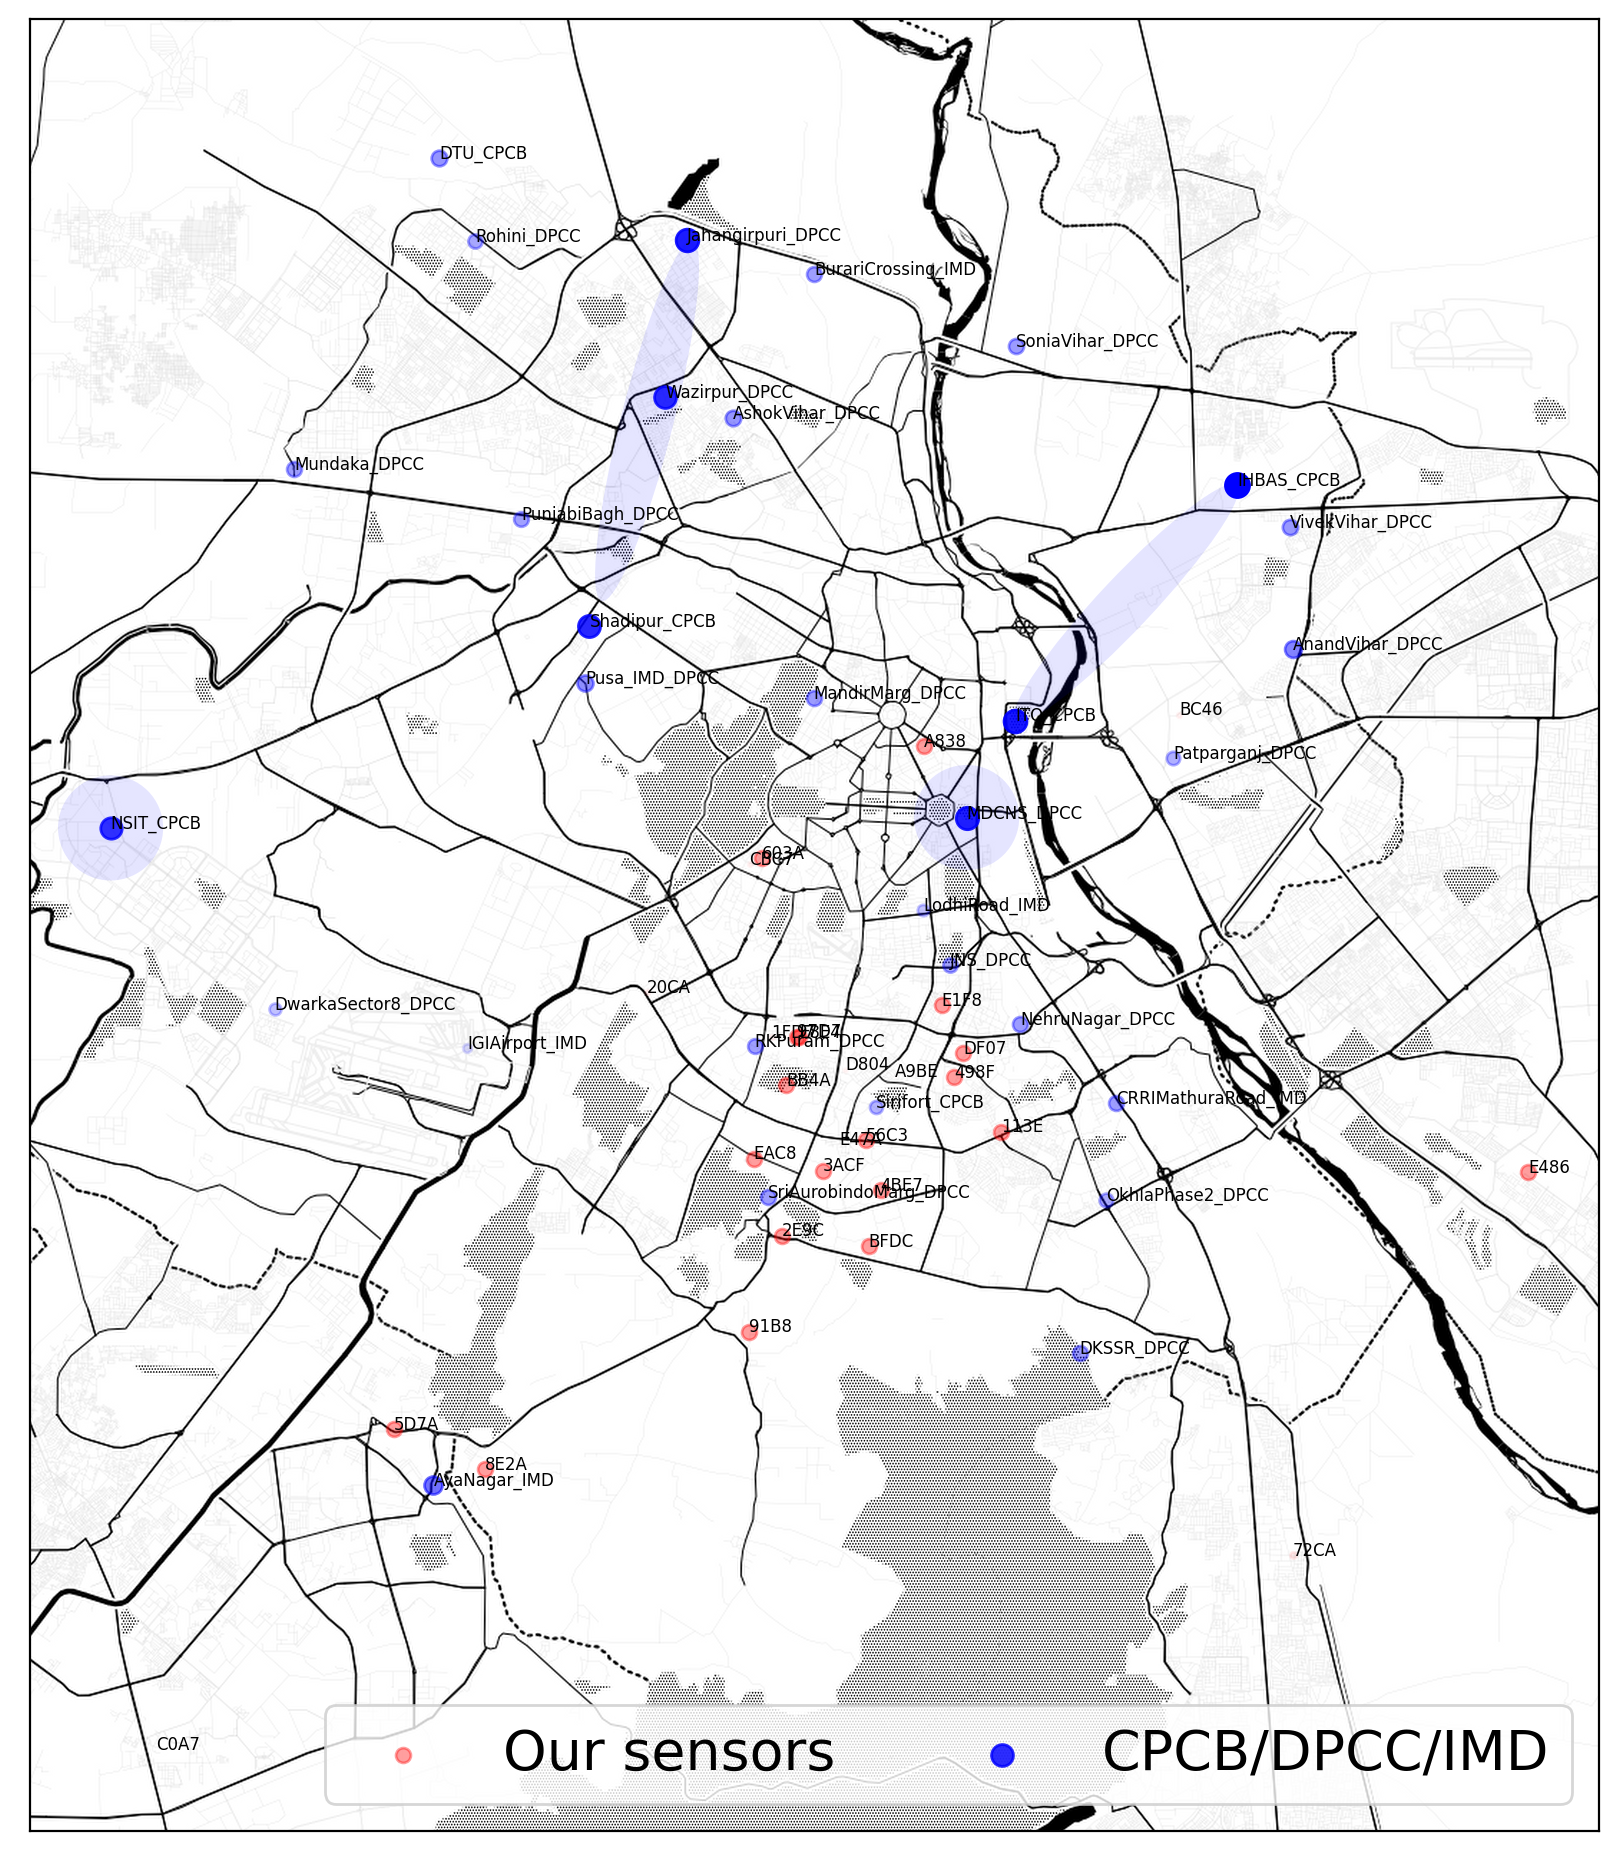

In [161]:
lat_lims = locs.Latitude.min(), locs.Latitude.max()
lon_lims = locs.Longitude.min(), locs.Longitude.max()
lon_center, lat_center = locs.Longitude.mean(), locs.Latitude.mean()


lat_pad = 1.1 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.1 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)

extent_proj = extent.to_project_3857

t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in locs_map.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r',\
                          s=300*val_df.loc[row.Index], label='Our sensors', alpha=val_df.loc[row.Index])
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b',\
                          s=300*val_df.loc[row.Index], label='CPCB/DPCC/IMD', alpha=val_df.loc[row.Index])
    ax.text(x, y, row.Index, fontsize=6)

ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)

cords = []
for hsp in hsps:
    cord_elt = []
    for l in hsp:
        x,y = tilemapbase.project(locs_map.loc[l].Longitude,\
                                  locs_map.loc[l].Latitude)
        cord_elt.append([x,y])
    cords.append(cord_elt)

el = []
for i in range(len(hsps)):
    cord = np.array(cords[i])
    x_mean = cord[:,0].mean()
    y_mean = cord[:,1].mean()
    if(len(hsps[i])==1):
        el.append(matplotlib.patches.Circle((x_mean,y_mean), 0.000035))
    if(len(hsps[i])>=2):
        x_max = max(cord[:,0])
        x_min = min(cord[:,0])
        y_max = max(cord[:,1])
        y_min = min(cord[:,1])
        x_diff = x_max-x_min
        y_diff = y_max-y_min
        slope = y_diff/x_diff
        slope = 90-math.degrees(math.atan(slope))
        diam = 2*math.sqrt(pow((x_mean-cord[0][0]),2) + pow((y_mean-cord[0][1]),2))
        el.append(matplotlib.patches.Ellipse((x_mean,y_mean),\
                                             0.000035,diam,slope))
    else:
        el.append(matplotlib.patches.Polygon(cord))
        

for e in el:
    ax.add_patch(e)
    e.set_clip_box(ax.bbox)
    e.set_facecolor('b')
    e.set_alpha(0.1)
ax.autoscale_view()
# plt.show()
plt.savefig('spatial_hotspots.png')

# Plot temporal hotspot

In [79]:
hsp = deepcopy(thsp_high['113E'][1])
hsp

[Timestamp('2018-10-13 06:00:00+0530', tz='pytz.FixedOffset(330)'),
 327.30555555555554,
 array([Timestamp('2018-10-12 09:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-12 12:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-12 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-12 18:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-12 21:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 03:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 06:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 09:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 12:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-10-13 15:00:00+0530', tz='pytz.FixedOffset(330)')],
       dtype=object)]

In [80]:
ts_le = hsp[2][0]
ts_rb = hsp[2][-1]
wind = len(hsp[2])

In [97]:
ts = hsp[0]

In [98]:
ts

Timestamp('2018-10-13 06:00:00+0530', tz='pytz.FixedOffset(330)')

In [82]:
idx = list(df['113E'].index)
idx_le = idx.index(ts_le)
idx_rb = idx.index(ts_rb)
idx_re = idx_rb+5*wind
idx_lb = idx_le-5*wind

In [84]:
idx_lb = max(0,idx_lb)
idx_re = min(idx_re,len(df))

In [85]:
idxs = np.array(idx)[idx_lb:idx_re+1]

In [95]:
idxs

array([Timestamp('2018-10-05 12:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-05 15:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-05 18:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-05 21:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 00:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 03:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 06:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 09:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 12:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 15:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 18:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-06 21:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-07 00:00:00+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2018-10-07 03:00:00+

In [99]:
np.where(idxs==ts)

(array([62]),)

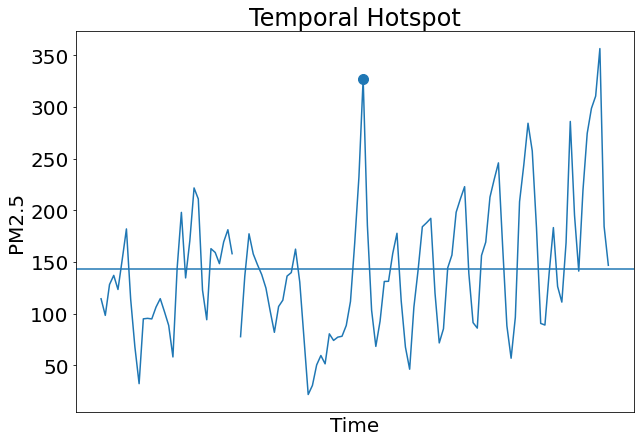

In [172]:
y = df['113E'].loc[idxs].values
x = range(len(y))
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(x,y)
plt.axhline(y=np.nanmean(y))
plt.scatter(x[62],y[62],s=100)
# ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title("Temporal Hotspot")
plt.savefig("temporal_hotspot.png")

In [116]:
y[62]

62